# Capstone Project Code
***

Import all the dependencies needed.

In [4]:
import numpy  as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)

import json
import lxml
import folium
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas          import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

import matplotlib        as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

Define Foursquare Credentials and Version.

In [3]:
CLIENT_ID     = '2O3GP5KHHQGMI34OA041Q3GJ22IVVNOZ44XIG0ZINICCHSPJ'
CLIENT_SECRET = 'O4DPWN5OUHUWEQ4F3N3DA3QNUBGZ22FAXA40P0QN1XPNKL0Y'
VERSION       = '20180605'
LIMIT         = 100
radius        = 500

Get the New York City Neighborhoods along with their latitude and longitude.

In [58]:
url  = 'https://cocl.us/new_york_dataset'
resp = requests.get(url).json()
features = resp['features']
    
column_names  = ['Borough','Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns = column_names)
    
for data in features:
    borough             = data['properties']['borough'] 
    neighborhood_name   = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat    = neighborhood_latlon[1]
    neighborhood_lon    = neighborhood_latlon[0]
    neighborhoods       = neighborhoods.append({'Borough': borough,
                                                'Neighborhood': neighborhood_name,
                                                'Latitude': neighborhood_lat,
                                                'Longitude': neighborhood_lon},
                                                ignore_index = True)  

Take a look at the data

In [59]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Get the list of all East Asian Restaurants

In [289]:
categories   = ["Japanese Restaurant", "Chinese Restaurant","Korean Restaurant"]
column_names = ['Borough', 'Neighborhood', 'Category', 'Name', 'Likes', 'Rating', 'ID', 'Latitude', 'Longitude']
restaurants  = pd.DataFrame(columns = column_names)

for neighborhood in neighborhoods.values.tolist():
    borough, neighborhood_name, latitude, longitude = neighborhood
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
           CLIENT_ID, 
           CLIENT_SECRET, 
           VERSION, 
           latitude, 
           longitude, 
           radius, 
           LIMIT)
    
    results = requests.get(url).json()
    venues  = results["response"]['groups'][0]['items']
    for venue in venues:
        category = venue['venue']['categories'][0]['name']
        if(category == categories[0] or category == categories[1] or category == categories[2]):
            venue_id        = venue['venue']['id']
            restaurant_name = venue['venue']['name']
            latitude        = venue['venue']['location']['lat']
            longitude       = venue['venue']['location']['lng']
            restaurants = restaurants.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Category': category,
                                              'Name': restaurant_name,
                                              'ID': venue_id,
                                              'Latitude': latitude,
                                              'Longitude': longitude},
                                              ignore_index = True)

Take a look at the data

In [290]:
restaurants.head()

,Borough,Neighborhood,Category,Name,Likes,Rating,ID,Latitude,Longitude
0,Bronx,Co-op City,Chinese Restaurant,Guang Hui Chinese Restaurant,NaN,NaN,4c9d5f2654c8a1cd2e71834b,40.876651,-73.829092
1,Bronx,Eastchester,Chinese Restaurant,Xing Lung Chinese Restaurant,NaN,NaN,4dabc3dc93a04642f09ccabd,40.888785,-73.831226
2,Bronx,Kingsbridge,Chinese Restaurant,Guan Hin Restaurant,NaN,NaN,4e3b11c98877b00cfc27a483,40.883705,-73.897896
3,Bronx,Kingsbridge,Chinese Restaurant,Yeung Hing Chinese Restsurant,NaN,NaN,4da39def540ea1cdfb3b95de,40.885175,-73.899405
4,Bronx,Norwood,Chinese Restaurant,Happy Dragon,NaN,NaN,4ce313fc438b224bbc6c80a3,40.880410,-73.883442


Use geopy library to get the latitude and longitude values of New York.

In [298]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="to_explorer")
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude

Create a map of New York City with Japanese Restaurants superimposed on top.

In [368]:
map_nyc = folium.Map(location = [latitude, longitude], zoom_start = 12)
df_map  = restaurants[restaurants.Category == categories[0]]

for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
    label = ""
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[0],
        fill=True,
        fill_color=colors[0],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Create a map of New York City with Chinese Restaurants superimposed on top.

In [301]:
map_nyc = folium.Map(location = [latitude, longitude], zoom_start = 12)
df_map  = restaurants[restaurants.Category == categories[1]]

for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
    label = ""
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[1],
        fill=True,
        fill_color=colors[1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Create a map of New York City with Korean Restaurants superimposed on top.

In [304]:
map_nyc = folium.Map(location = [latitude, longitude], zoom_start = 12)
df_map  = restaurants[restaurants.Category == categories[2]]

for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
    label = ""
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[2],
        fill=True,
        fill_color=colors[2],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Plot the number of Japanese resturants in each Borough.

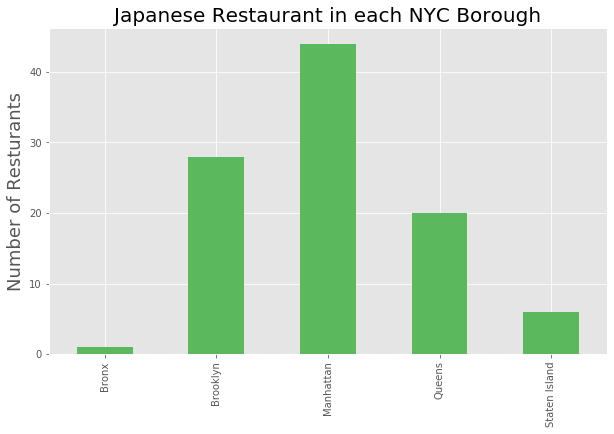

In [239]:
colors = ['#5cb85c', '#5bc0de', '#d9534f']

df_plt = restaurants[restaurants.Category == categories[0]].groupby('Borough')['Name'].count()
df_plt.plot(kind='bar', figsize=(10, 6), color = colors[0])
plt.title(categories[0] +' in each NYC Borough', fontsize = 20)
plt.ylabel('Number of Resturants', fontsize = 18)
plt.xlabel('')
plt.show()

Plot the number of Chinese resturants in each Borough.

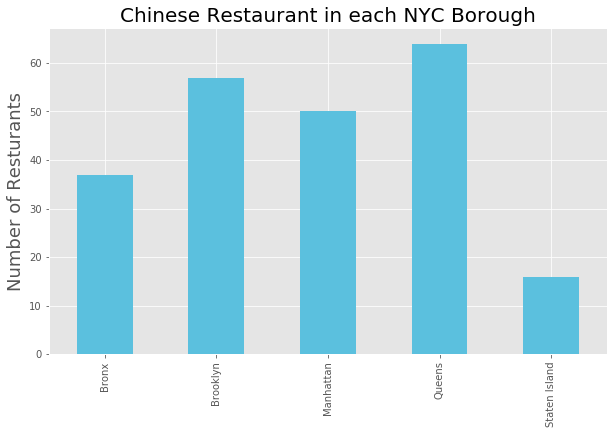

In [240]:
df_plt = restaurants[restaurants.Category == categories[1]].groupby('Borough')['Name'].count()
df_plt.plot(kind='bar', figsize=(10, 6), color = colors[1])
plt.title(categories[1] +' in each NYC Borough', fontsize = 20)
plt.ylabel('Number of Resturants', fontsize = 18)
plt.xlabel('')
plt.show()

Plot the number of Korean resturants in each Borough.

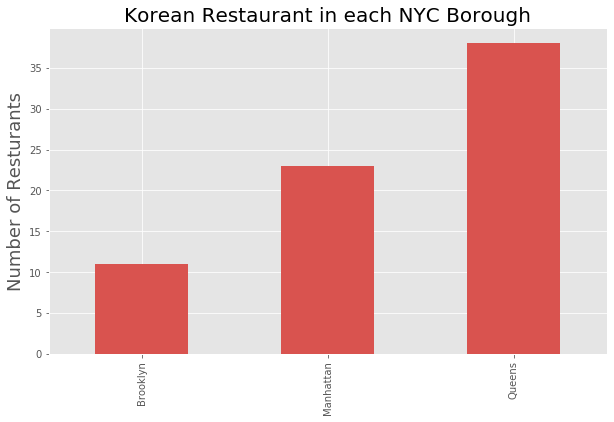

In [241]:
df_plt = restaurants[restaurants.Category == categories[2]].groupby('Borough')['Name'].count()
df_plt.plot(kind='bar', figsize=(10, 6), color = colors[2])
plt.title(categories[2] +' in each NYC Borough', fontsize = 20)
plt.ylabel('Number of Resturants', fontsize = 18)
plt.xlabel('')
plt.show()

Create a map of New York City with All East Asian Restaurants superimposed on top.

In [305]:
map_nyc = folium.Map(location = [latitude, longitude], zoom_start = 12)
df_map  = restaurants

for lat, lng, cat in zip(df_map['Latitude'], df_map['Longitude'], df_map['Category']):
    label = ""
    if(cat == categories[0]):
        color = colors[0]
    elif(cat == categories[1]):
        color = colors[1]
    else:
        color = colors[2]
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

Plot the number of East Asian resturants in the same graph.

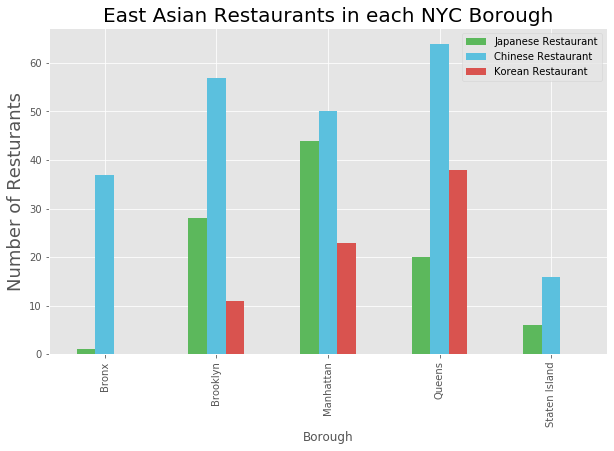

In [242]:
df_plt = restaurants[restaurants.Category == categories[0]].groupby('Borough')['Name'].count()
df_plt = pd.DataFrame(df_plt)
df_plt.columns = [categories[0]]

new_column = pd.DataFrame(restaurants[restaurants.Category == categories[1]].groupby('Borough')['Name'].count())
df_plt = df_plt.join(new_column, on = "Borough")
df_plt.columns = [categories[0],categories[1]]

new_column = pd.DataFrame(restaurants[restaurants.Category == categories[2]].groupby('Borough')['Name'].count())
df_plt = df_plt.join(new_column, on = "Borough")
df_plt.columns = [categories[0],categories[1],categories[2]]

df_plt.plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('East Asian Restaurants in each NYC Borough', fontsize = 20)
plt.ylabel('Number of Resturants', fontsize = 18)
#plt.xlabel('')
plt.show()

Plot the number of East Asian resturants in each neighborhood

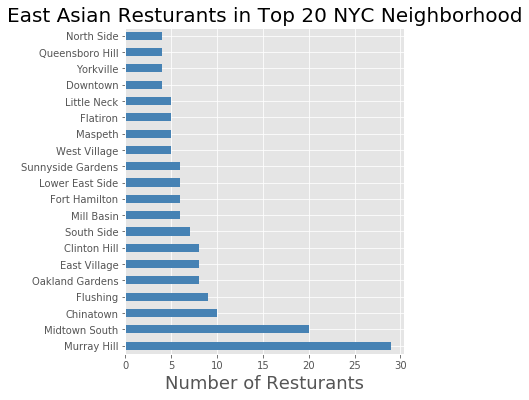

In [243]:
df_plt = restaurants.groupby('Neighborhood')['Name'].count().sort_values(ascending = False).head(20)
df_plt.plot(kind='barh', figsize=(5, 6), color='steelblue')
plt.title('East Asian Resturants in Top 20 NYC Neighborhood', fontsize = 20)
plt.xlabel('Number of Resturants', fontsize = 18)
plt.ylabel('')
plt.show()

Get the list of all East Asian Restaurants with detail Likes and Rating.

In [331]:
for i, ID in zip(restaurants.index, restaurants['ID']):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
           ID,
           CLIENT_ID, 
           CLIENT_SECRET, 
           VERSION)
    results    = requests.get(url).json()
    venue_data = results['response']['venue']
    try:
        restaurants.at[i, 'Likes']  = venue_data['likes']['count']
        restaurants.at[i, 'Rating'] = venue_data['rating']
    except KeyError:
        pass

KeyError: 'venue'

Take a look at the data.

In [364]:
restaurants.head(10)

,Borough,Neighborhood,Category,Name,Likes,Rating,ID,Latitude,Longitude
5,Bronx,Pelham Parkway,Chinese Restaurant,Mr. Q's Chinese Restaurant,9.0,7.4,4b9d6b45f964a52078ab36e3,40.855790,-73.855455
6,Bronx,Bedford Park,Chinese Restaurant,Choi Yuan - Chinese Restaurant,6.0,6.9,4e2e08021838f1c552b6b8eb,40.873078,-73.889086
7,Bronx,Bedford Park,Chinese Restaurant,Hung Hing Chinese Restaurant,5.0,5.9,4e4d0387bd413c4cc66dfd72,40.871181,-73.886759
11,Bronx,Fordham,Chinese Restaurant,Panda Express,12.0,7.6,566f33e7498e44c2501bda81,40.863001,-73.900894
20,Bronx,Parkchester,Chinese Restaurant,Sabor Latino Seafood Restaurant,6.0,7.1,4b89b62df964a520ff4c32e3,40.836366,-73.853034
21,Bronx,Belmont,Japanese Restaurant,Sake II,6.0,7.1,4baeef6bf964a520cbe23be3,40.854265,-73.884616
22,Bronx,North Riverdale,Chinese Restaurant,Golden Phoenix Chinese Restaurant,4.0,5.7,4ca4fda4d971b1f77da5f2e0,40.905689,-73.904298
27,Bronx,Concourse,Chinese Restaurant,Lucky House Chinese Restaurant,5.0,7.4,4d9a695ee5fd6ea8e3096df5,40.833933,-73.916674
28,Brooklyn,Bay Ridge,Chinese Restaurant,XIN,6.0,7.4,5553702c498ecb85f99d8f37,40.625082,-74.030494
29,Brooklyn,Bay Ridge,Chinese Restaurant,86 Noodles,19.0,7.4,4a5beec3f964a52006bc1fe3,40.622573,-74.028423


Drop those rows with no rating.

In [365]:
restaurants = restaurants.dropna()

Take a look at the data.

In [366]:
restaurants.head()

,Borough,Neighborhood,Category,Name,Likes,Rating,ID,Latitude,Longitude
5,Bronx,Pelham Parkway,Chinese Restaurant,Mr. Q's Chinese Restaurant,9.0,7.4,4b9d6b45f964a52078ab36e3,40.855790,-73.855455
6,Bronx,Bedford Park,Chinese Restaurant,Choi Yuan - Chinese Restaurant,6.0,6.9,4e2e08021838f1c552b6b8eb,40.873078,-73.889086
7,Bronx,Bedford Park,Chinese Restaurant,Hung Hing Chinese Restaurant,5.0,5.9,4e4d0387bd413c4cc66dfd72,40.871181,-73.886759
11,Bronx,Fordham,Chinese Restaurant,Panda Express,12.0,7.6,566f33e7498e44c2501bda81,40.863001,-73.900894
20,Bronx,Parkchester,Chinese Restaurant,Sabor Latino Seafood Restaurant,6.0,7.1,4b89b62df964a520ff4c32e3,40.836366,-73.853034


Create a new column with the average rating for each neighborhood.

In [346]:
new_column = restaurants.groupby('Neighborhood',as_index = False).mean()[['Neighborhood','Rating']]
neighborhoods = neighborhoods.join(new_column.set_index('Neighborhood'), on = 'Neighborhood')

Plot the best average rating of East Asian resturants by neighborhood.

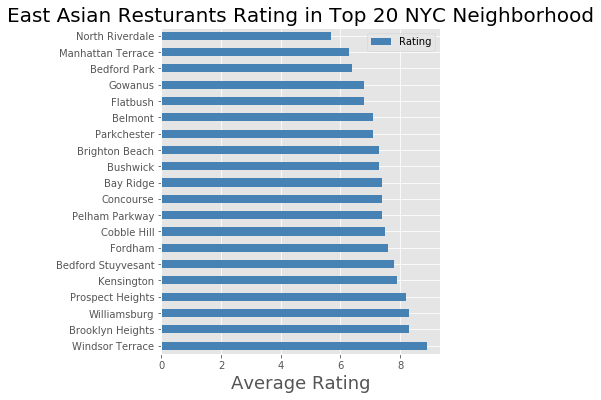

In [367]:
df_plt = neighborhoods.sort_values(['Rating'],ascending=False).head(20)
df_plt = df_plt[['Neighborhood','Rating']].set_index('Neighborhood')
df_plt.plot(kind='barh', figsize=(5, 6), color='steelblue')
plt.title('East Asian Resturants Rating in Top 20 NYC Neighborhood', fontsize = 20)
plt.xlabel('Average Rating', fontsize = 18)
plt.ylabel('')
plt.show()